## MultiObjectiveBO

In [1]:
import torch
from mo_bayes_opt import MultiObjectiveBO

def joint_objective(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    interaction = torch.sin(5 * torch.pi * x1 * x2)
    f1 = ((x[:, :3] * torch.sin(3 * torch.pi * x[:, :3])).sum(dim=-1) + 0.5 * interaction)
    f2 = (((1 - x[:, 3:]) * torch.cos(3 * torch.pi * x[:, 3:])).sum(dim=-1) - 0.3 * interaction)
    return torch.stack([f1, f2], dim=-1)

input_dim = 2
output_dim = 2

bo = MultiObjectiveBO(
    objective_fn=joint_objective,
    input_dim=2,
    bounds=torch.tensor([[0.0] * input_dim, [1.0] * input_dim]),
    ref_point=torch.tensor([-1.0] * output_dim),
    strategy="EHVI",
    use_adaptive_noise=False,
    save_models=True,
)
hypervolumes = bo.run(num_repeats=1, num_queries=100, log_path="log.csv")


Trial 0


  4%|▍         | 4/100 [00:06<02:34,  1.61s/it]

#### Get History

In [ ]:
logger = bo.logger
history = logger.get_history()

#### plot pareto

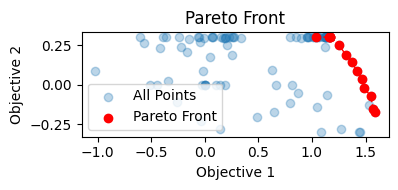

In [ ]:
from mo_bayes_opt.utils.visualization import plot_pareto

train_x = history[0][-1]["train_x"]
train_y = history[0][-1]["train_y"]
plot_pareto(train_y)

## Prediction

In [ ]:
models = history[0][-1]["models"]

In [ ]:
# 假设你已经训练好最后一个模型：
model1 = models[0]  # or model2
model2 = models[1]

#### 1d prediction

In [ ]:
import matplotlib.pyplot as plt

def plot_gp(model, test_x, mean, std):
    plt.figure(figsize=(4, 1.5))
    plt.plot(test_x.numpy(), mean.numpy(), 'b-', label='Mean')
    plt.fill_between(test_x.squeeze().numpy(),
                     (mean - 1.96 * std).numpy(),
                     (mean + 1.96 * std).numpy(),
                     color='lightblue', alpha=0.5, label='95% CI')
    # plt.title('GP Prediction')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.legend(frameon=False, ncol=2)
    # plt.show()

In [ ]:
x1 = torch.linspace(0, 1, 100)
x2 = torch.ones(100) * 0.5  # 固定 x2 为 0.5
test_x = torch.stack([x1, x2], dim=-1)

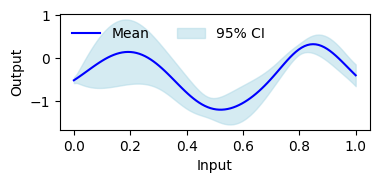

In [ ]:
mean, std = model1.predict_mean_std(test_x)
plot_gp(model1, x1, mean, std)
plt.savefig('gp_model1.png', dpi = 300, bbox_inches='tight')

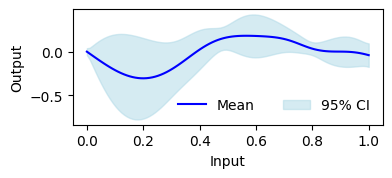

In [ ]:
mean, std = model2.predict_mean_std(test_x)
plot_gp(model2, x1, mean, std)
plt.savefig('gp_model2.png', dpi=300, bbox_inches='tight')

#### 2d prediction

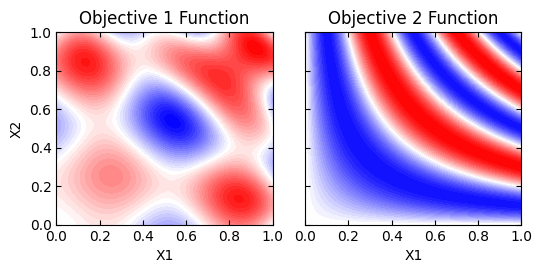

In [ ]:
test_x = torch.linspace(0, 1, 100).unsqueeze(-1).repeat(1, input_dim)  # 100 个点
X, Y = torch.meshgrid(test_x[:, 0], test_x[:, 1], indexing='ij')
Z = joint_objective(torch.stack([X.flatten(), Y.flatten()], dim=-1)).reshape(X.shape[0], X.shape[1], -1)

fig, axs = plt.subplots(1, 2, figsize=(6, 2.5))
plt.subplots_adjust(wspace=0.15)
# 绘制第一个目标函数的预测
axs[0].contourf(X.numpy(), Y.numpy(), Z[:, :, 0].numpy(), levels=50, cmap='bwr')
axs[0].set_title('Objective 1 Function')
axs[0].set_xlabel('X1')
axs[0].set_ylabel('X2')
# 绘制第二个目标函数的预测
axs[1].contourf(X.numpy(), Y.numpy(), Z[:, :, 1].numpy(), levels=50, cmap='bwr')
axs[1].set_title('Objective 2 Function')
axs[1].set_xlabel('X1')
axs[1].set_ylabel('X2')
# plt.tight_layout()

for ax in axs.flatten():
    ax.tick_params(direction='in', top=True, right=True)
    ax.label_outer()

plt.savefig('objective_functions.png')

In [ ]:
def predict_matrix(model, X, Y):
    predict_x = torch.concat([X.flatten().unsqueeze(-1), Y.flatten().unsqueeze(-1)], dim=-1)
    pred_mean, pred_std = model.predict_mean_std(predict_x)
    pred_mean = pred_mean.reshape(X.shape[0], X.shape[1])
    pred_std = pred_std.reshape(X.shape[0], X.shape[1])
    return pred_mean, pred_std

pred1_mean, pred1_std = predict_matrix(model1, X, Y)
pred2_mean, pred2_std = predict_matrix(model2, X, Y)

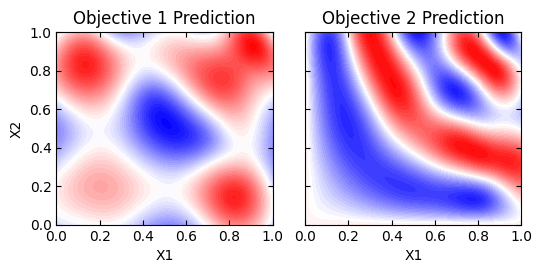

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5))
plt.subplots_adjust(wspace=0.15)
# 绘制第一个目标函数的预测
axs[0].contourf(X.numpy(), Y.numpy(), pred1_mean.numpy(), levels=50, cmap='bwr')
axs[0].set_title('Objective 1 Prediction')
axs[0].set_xlabel('X1')
axs[0].set_ylabel('X2')
# 绘制第二个目标函数的预测
axs[1].contourf(X.numpy(), Y.numpy(), pred2_mean.numpy(), levels=50, cmap='bwr')
axs[1].set_title('Objective 2 Prediction')
axs[1].set_xlabel('X1')
axs[1].set_ylabel('X2')
# plt.tight_layout()

for ax in axs.flatten():
    ax.tick_params(direction='in', top=True, right=True)
    ax.label_outer()

plt.savefig('predictions.png')

In [ ]:
# slice_x_idx = 50
# slice_x = X[slice_x_idx, :]


# fig, axs = plt.subplots(1, 2, figsize=(12, 5))